In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import utils
import tensorflow as tf

num_layers = 1
num_steps = 1
input_size = 1
embed_size = 1
learning_rate = 0.0000001
num_lstm = 512
random_wav = "bass_electronic_018-022-100.wav"

audio = utils.load_audio(random_wav)
sample_length = audio.shape[0]
print(sample_length)
audio = np.concatenate((audio, audio))

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


64000


In [4]:
import numpy as np
import pandas as pd
import random

#normalized does not work
class dt():
    def __init__(self, raw_audio, input_size = input_size, num_steps = num_steps, test_ratio = 0.1, normalized = False):
        self.raw_seq = np.array(raw_audio)
        self.input_size = input_size
        self.num_steps = num_steps 
        self.test_ratio = test_ratio
        self.normalized = normalized
        self.train_X, self.train_y, self.test_X, self.test_y = self._prepare_data(self.raw_seq)

    def _prepare_data(self, seq):
        # split into items of input_size
        seq = [np.array(seq[i * self.input_size: (i + 1) * self.input_size])
               for i in range(len(seq) // self.input_size)]
        
        if self.normalized:
            seq = [seq[0] / seq[0][0] - 1.0] + [
                curr / seq[i][-1] - 1.0 for i, curr in enumerate(seq[1:])]

        # split into groups of num_steps
        X = np.array([seq[i: i + self.num_steps] for i in range(len(seq) - self.num_steps)])
        y = np.array([seq[i + self.num_steps] for i in range(len(seq) - self.num_steps)])

        train_size = int(len(X) * (1.0 - self.test_ratio))
        train_X, test_X = X[:train_size], X[train_size:]
        train_y, test_y = y[:train_size], y[train_size:]
        return train_X, train_y, test_X, test_y

    def generate_one_epoch(self, batch_size):
        num_batches = int(len(self.train_X)) // batch_size
        if batch_size * num_batches < len(self.train_X):
            num_batches += 1

        batch_indices = list(range(num_batches))
        random.shuffle(batch_indices)
        for j in batch_indices:
            batch_X = self.train_X[j * batch_size: (j + 1) * batch_size]
            batch_y = self.train_y[j * batch_size: (j + 1) * batch_size]
            assert set(map(len, batch_X)) == {self.num_steps}
            yield batch_X, batch_y

In [5]:
tf.reset_default_graph()
#time, batch, depth
encoder_inputs_t = tf.placeholder(shape=(None, num_steps, input_size), dtype=tf.float32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, input_size), dtype=tf.float32, name='decoder_targets')
decoder_inputs_t = tf.placeholder(shape=(None, num_steps, input_size), dtype=tf.float32, name='decoder_inputs')
decoder_inputs = tf.transpose(decoder_inputs_t, [1, 0, 2])
encoder_inputs = tf.transpose(encoder_inputs_t, [1, 0, 2])

cell = tf.contrib.rnn.LSTMCell(num_lstm)
encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    cell, encoder_inputs_t,
    dtype=tf.float32, time_major=True,
)
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    cell, decoder_inputs_t,
    initial_state=encoder_final_state,
    dtype=tf.float32, time_major=True,
)

#prediction = decoder_outputs
#output_shape = tf.shape(decoder_outputs)
#prediction = tf.reshape(decoder_outputs, [-1, input_size]) #TODO: why?
prediction, *_ = tf.unstack(decoder_outputs, axis = 2)
#prediction = tf.nn.softmax(decoder_outputs) #TODO: why?
#print(tf.shape(prediction))
loss = tf.reduce_mean((tf.square(decoder_outputs - encoder_inputs)))
optimizer =  tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

In [ ]:
batch_size = 100
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    global_step = 0
    epoch_step = 0
    d = dt(audio, test_ratio=0)
    batch_labels = np.ones(d.train_X.shape)
    test_data_feed = {
            encoder_inputs_t: d.train_X,
            decoder_targets: d.train_y,
            decoder_inputs_t: batch_labels,
    }
    bc = sess.run(prediction, test_data_feed)
    #test_loss, test_pred = sess.run([loss, prediction], test_data_feed)

In [176]:
backup_bc = bc
bc.shape

(127999, 1)

In [24]:
def _flatten(seq):
    return [x for y in seq for x in y]
pred = np.array([])
batch_size = 100
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    merged_test_X = np.array(audio)
    merged_test_y = np.array(audio)

    global_step = 0
    epoch_step = 0
    d = dt(audio, test_ratio=0)

    for batch_x, batch_y in d.generate_one_epoch(batch_size):
        global_step += 1
        epoch_step += 1
        batch_labels = np.ones(batch_x.shape)
        train_data_feed = {
            encoder_inputs_t: batch_x,
            decoder_targets: batch_y,
            decoder_inputs_t: batch_labels,
        }
        train_loss, _ = sess.run([loss, optimizer], train_data_feed)
        if(global_step % 100 == 1):
            print(train_loss)
        
            
    for batch_x, batch_y in d.generate_one_epoch(batch_size):
        global_step += 1
        epoch_step += 1
        batch_labels = np.ones(batch_x.shape)
        train_data_feed = {
            encoder_inputs_t: batch_x,
            decoder_targets: batch_y,
            decoder_inputs_t: batch_labels,
        }
        train_loss, train_pred = sess.run([loss, prediction], train_data_feed)
        preds = np.array(_flatten(train_pred))
        pred = np.concatenate([pred, preds]) 
        if(global_step % 100 == 1):
            print(train_loss)
            

0.00102576
7.14943e-05
3.07043e-05
2.05792e-05
1.2578e-05
1.01232e-05
7.21621e-06
5.87181e-06
4.37601e-06
0.000292791
3.06565e-06
2.11795e-06
1.60492e-06
1.30074e-06


KeyboardInterrupt: 

(15200,)


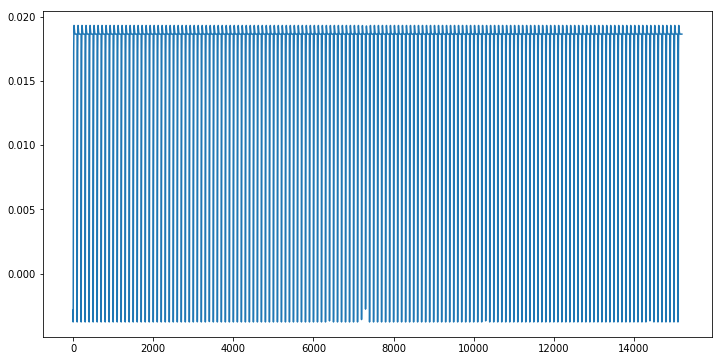

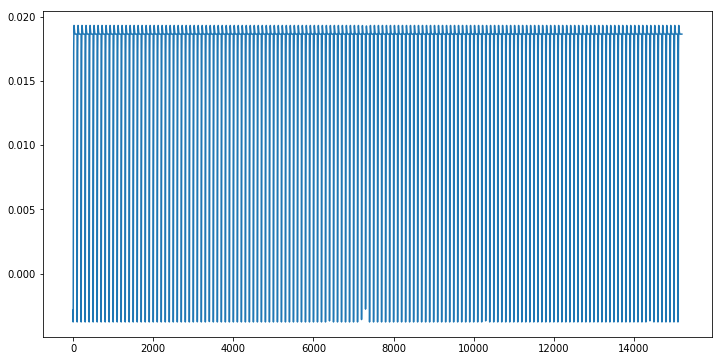

In [23]:
pred.shape

days = np.array(range(len(pred))[-127999:])
print(days.shape)

plt.figure(figsize=(12, 6))
#lt.plot(days, truths, label='truth')
plt.plot(days, pred, label='pred')
plt.show()

In [21]:


truths = np.array(audio[:-1])
preds = np.array(_flatten(test_pred))
print(truths.shape)
print(preds.shape)
days = np.array(range(len(truths))[-127999:])
print(days.shape)

plt.figure(figsize=(12, 6))
plt.plot(days, truths, label='truth')
plt.plot(days, preds, label='pred')
plt.legend(loc='upper left', frameon=False)
plt.xlabel("time")
plt.ylabel("amplitute")
plt.ylim((min(truths), max(truths)))
plt.grid(ls='--')
plt.show()

NameError: name 'test_pred' is not defined

In [136]:
print(test_pred.shape)

(1, 127999)
